In [9]:
import netCDF4
import xarray as xr
import dask
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import transforms
from matplotlib.animation import PillowWriter

In [10]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/Small_Sample/New_SPCAM5/TimestepOutput_Neuralnet_SPCAM_216/run/Cpac_gridcell_rcat.nc'
test_ds = xr.open_dataset(path_to_file)
#test_ds.variables

In [11]:
def plotting(datas, varname, title):
    hours = np.arange(0, len(datas), 1)/4
    plt.plot(hours, datas, linewidth = 4)
    plt.xlabel('Hour', fontsize = 20)
    plt.ylabel(varname, fontsize = 20)
    plt.title('Time series for '+title+' location')

Make some time plots for temperature?

In [12]:
T = test_ds.T.values
T = np.squeeze(T)

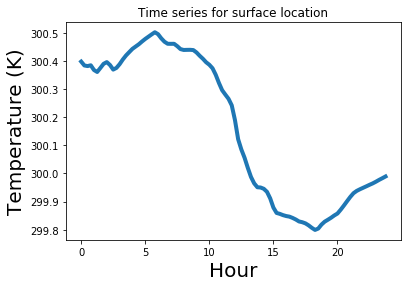

In [13]:
var = 'Temperature (K)'
location = 'surface'
plotting(T[:, -1], var, location)

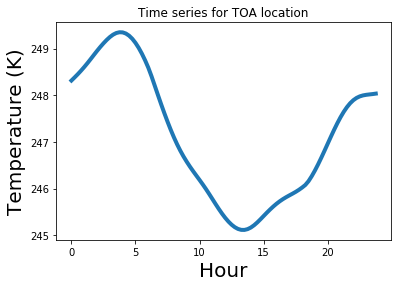

In [14]:
location = 'TOA'
plotting(T[:, 0], var, location)

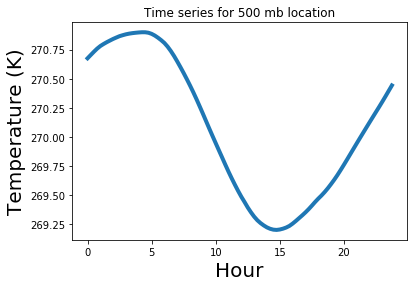

In [15]:
location = '500 mb'
plotting(T[:, -12], var, location)

Get moist static energy information



$S = c_p*T+g*z+L_v*q$


cp = specific heat of air ($\frac{Joules}{kg*K}$)

T = temperature (K)

g = gravity constant ($\frac{m}{s^2}$)

z = altitude (m)

$L_v$ is latent heat of Vaporization $\frac{Joules}{kg}$

q = Specific humidity $\frac{kg}{kg}$


Steps:

- Import temperature and multiply by $C_p$
- import specific humidity and multiply by $L_v$ from AMS glossery
- convert pressure level to altitude in meters and multiply by gravity constant


Steps above should transfer all terms to units of $\frac{m^2}{s^2}$ a.k.a. $\frac{Joules}{kilogram}$


In [16]:
def altitude_converter(pressure_array):
    T_avg = 250.0
    H = T_avg*287.0/9.81
    z_array = np.log(pressure_array/1013.25)*(-1.0*H)
    return z_array

#altitude_converter(pres[-1])

In [17]:
#Constants
g = 9.81
Lv = 2501000.0
cp = 1004.0


Q = test_ds.QBP.values
Q = np.squeeze(Q) 
pres = test_ds.lev.values

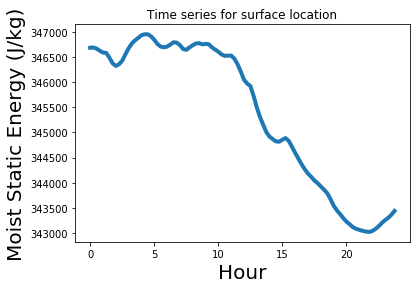

In [18]:
def MSE_gen(temp_array, humidity_array, p_level):
    enthalpy = temp_array*1004.0+humidity_array*2501000.0
    z = altitude_converter(p_level)
    zs = np.zeros(shape=len(enthalpy))
    zs[:] = z*9.81
    MSE = enthalpy+zs
    return MSE

var = 'Moist Static Energy (J/kg)'
location = 'surface'
MSE = MSE_gen(T[:,-1], Q[:,-1], pres[-1])
plotting(MSE, var, location)

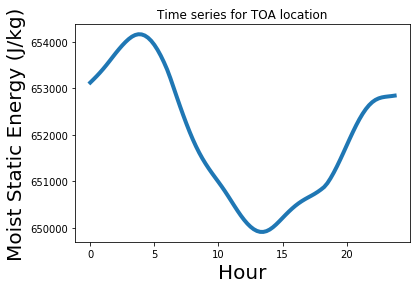

In [19]:
location = 'TOA'
MSE = MSE_gen(T[:,0], Q[:,0], pres[0])
plotting(MSE, var, location)

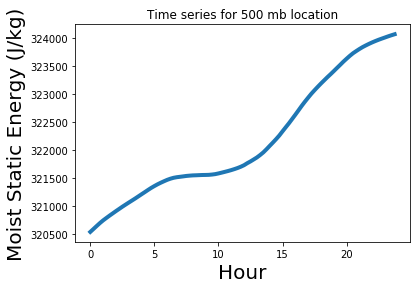

In [20]:
location = '500 mb'
MSE = MSE_gen(T[:,-12], Q[:,-12], pres[-12])
plotting(MSE, var, location)

Some Animations through the day?

In [21]:
#fix the pressure levels
ps = test_ds.PS.values
hyam = test_ds.hyam.values
hybm = test_ds.hybm.values

print(ps[0])

[[101025.195]]


In [22]:
x = 144
y = 96
tt = 16
z = 30
#For grid that takes into account levels
#SPCAM5
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")

#Open up the variables
lons = np.array(others.variables['lon'])
lats = np.array(others.variables['lat'])
times = np.array(others.variables['time'])
ps = np.array(others.variables['PS'])
#SPCAM5
pttend = np.array(others.variables['PTTEND'])
#SPCAM3
#pttend = np.array(others.variables['TPHYSTND'])
levs = np.array(others.variables['lev'])

p = np.zeros(shape=(x, y, z, tt))
print(ps.shape)
#formula
hyam = np.array(others.variables['hyam'])
hybm = np.array(others.variables['hybm'])

#loop over longitude
for i in range(len(p)):
    #loop over latitude
    for j in range(len(p[0])):
        #loop over time
        for k in range(len(p[0][0][0])):
            p_temp = hyam + ps[k][j][i]*hybm
            p[i,j,:,k] = p_temp/100.
        

#simple mesh grid
Xvar, Yvar = np.meshgrid(lons, levs)
Xs, Ys = np.meshgrid(lats, levs)
ilat = []
for i in range(len(lats)):
    if lats[i] < 10.0 or lats[i] > -10.0:
        ilat.append(lats[i])
        
ilat = np.array(ilat)

#CORRECT WAY - longitude:
#pband = np.nanmean(p,axis = 3)
#pband = np.nanmean(pband,axis = 0)
#correct way - latitude
pband = np.nanmean(p,axis = 3)
pband = np.nanmean(pband,axis = 1)

(16, 96, 144)


In [23]:
relevant_pressures = np.squeeze(pband[72, :])

In [24]:
def MSE_column_gen(temp_array, humidity_array, p_level):
    enthalpy = temp_array*1004.0+humidity_array*2501000.0
    z = altitude_converter(p_level)
    zs = np.zeros(shape =(len(enthalpy), len(enthalpy[0])))
    for i in range(len(zs)):
        zs[i, :] = z*9.81
    MSE = enthalpy+zs
    return MSE

#MSE_column_gen(T, Q, relevant_pressures)

In [25]:
MSE = MSE_column_gen(T, Q, relevant_pressures)
print(MSE.shape)

(96, 30)


In [26]:
def utc_timing(times):
    utc_list = []
    end_times = [':00',':15',':30',':45']
    counter = 0
    thing = 0
    for i in range(times):
        if thing == 95:
            thing = 0
        
        beg_time = int(thing/4)
        if beg_time == 0:
            beg_time = 24
        ending = end_times[counter]
        counter = counter + 1
        if counter  == 4:
            counter = 0
        
        utc_time = str(beg_time)+ending
        utc_list.append(utc_time)
        thing = thing + 1
        
        
    
    #print(utc_list)
    return utc_list

In [27]:
varname = "Moist Static Energy"
units = "(J/kg)"
savepath = 'MoistStaticEnergy'

def anime_col(pressures, values, var, unit, save):
    plt.rcParams['animation.ffmpeg_path'] = '/export/home/gmooers/miniconda3/bin/ffmpeg'
    container = []

    
    fig, ax = plt.subplots(1, 1)
    times = len(values)
    utc_list = utc_timing(times)
    for i in range(times):
        
        if i == 1:
                plt.ylabel("Pressure")
                plt.xlabel(var+' '+unit)
            
    
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(270)
    
        column_plot_targ, = ax.plot(pressures, np.squeeze(values[i,:]), color = 'blue', transform = rot + base, animated = True)
        title_feat = ax.text(0.5,1.05," Moist Static Energy the Column (0N, 180E) at "+utc_list[i], 
                    size=10,
                    ha="center", transform=ax.transAxes, )
        
        my_yticks = np.arange(0, 1400, 200)
        my_yticks[::-1].sort()
        ax.set_yticklabels(my_yticks)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
        container.append([column_plot_targ, title_feat])
        #start = start + interval
      
    ani = animation.ArtistAnimation(fig, container, interval = 150, blit = True, repeat = True)
    ani.save('/fast/gmooers/Figures/Animate/0N_180E_Single_Col_Single_Day_'+save+'_Animations.mp4')
    #plt.show()
    
#anime_col(relvant_pressures, MSE, varname, units, savepath)

In [28]:
varname = "Temerature"
units = "(K)"
savepath = 'Temperature'

#anime_col(relvant_pressures, T, varname, units, savepath)